In [1]:
from pandas import *
set_option('display.max_rows', 1000)
%matplotlib inline  

# D_ICD_DIAGNOSES.csv

Notes:
    - Need this data frame for code name to actual medical name
    - will be used to do merge on key to understand what ICD9 code is
    - can use to aggregate like medical diagnoses together

In [2]:
df_D_ICD_DIAGNOSES = read_csv("D_ICD_DIAGNOSES.csv")
df_D_ICD_DIAGNOSES.head()

,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,174,01166,TB pneumonia-oth test,"Tuberculous pneumonia [any form], tubercle bac..."
1,175,01170,TB pneumothorax-unspec,"Tuberculous pneumothorax, unspecified"
2,176,01171,TB pneumothorax-no exam,"Tuberculous pneumothorax, bacteriological or h..."
3,177,01172,TB pneumothorx-exam unkn,"Tuberculous pneumothorax, bacteriological or h..."
4,178,01173,TB pneumothorax-micro dx,"Tuberculous pneumothorax, tubercle bacilli fou..."


Notes:
    - Example of what ICD9_CODE 4280 corresponds to (Congestive heart failure, unspecified)

In [3]:
df_D_ICD_DIAGNOSES[df_D_ICD_DIAGNOSES['ICD9_CODE'] == '4280']

,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
4472,4473,4280,CHF NOS,"Congestive heart failure, unspecified"


# DIAGNOSES_ICD.csv

Notes:
    - HADM_ID is a unique identifier used on the subject per visit, for example HADM_ID 1, and 
    HADM_ID 3009 corresponds to two different patient visits and what ICD9_CODE is associated with 
    the visit

In [4]:
df_DIAGNOSES_ICD = read_csv("DIAGNOSES_ICD.csv")
df_DIAGNOSES_ICD.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1.0,40301
1,1298,109,172335,2.0,486
2,1299,109,172335,3.0,58281
3,1300,109,172335,4.0,5855
4,1301,109,172335,5.0,4254


Notes:
    - showing the top 100 ICD9 codes used by count

In [5]:
df_CD9_CODE_count = df_DIAGNOSES_ICD.groupby(['ICD9_CODE']).count().reset_index()
merge_count_df = df_CD9_CODE_count.merge(df_D_ICD_DIAGNOSES, on='ICD9_CODE')
merge_count_df = merge_count_df[['ICD9_CODE', 'ROW_ID_x', 'LONG_TITLE']]
merge_count_df.columns = ['ICD9_CODE', 'COUNT', 'LONG_TITLE']
merge_count_df_n100 = merge_count_df.sort_values(by='COUNT', ascending=False).head(100)
print(merge_count_df_n100)

     ICD9_CODE  COUNT                                         LONG_TITLE
1920      4019  20703                 Unspecified essential hypertension
2066      4280  13111              Congestive heart failure, unspecified
2055     42731  12891                                Atrial fibrillation
1977     41401  12429  Coronary atherosclerosis of native coronary ar...
2897      5849   9119                  Acute kidney failure, unspecified
811      25000   9058  Diabetes mellitus without mention of complicat...
931       2724   8690               Other and unspecified hyperlipidemia
2484     51881   7497                          Acute respiratory failure
2965      5990   6555        Urinary tract infection, site not specified
2576     53081   6326                                  Esophageal reflux
928       2720   5930                          Pure hypercholesterolemia
6396      V053   5779  Need for prophylactic vaccination and inoculat...
6576      V290   5519     Observation for suspected

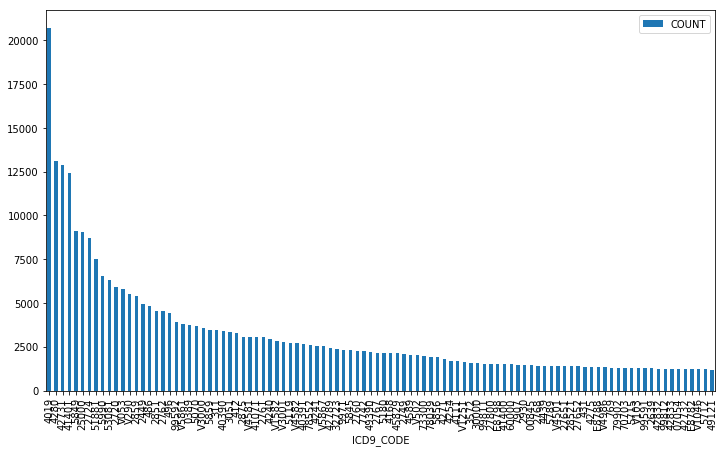

In [6]:
merge_count_df_n100.plot.bar(x='ICD9_CODE', y='COUNT', figsize=(12, 7))

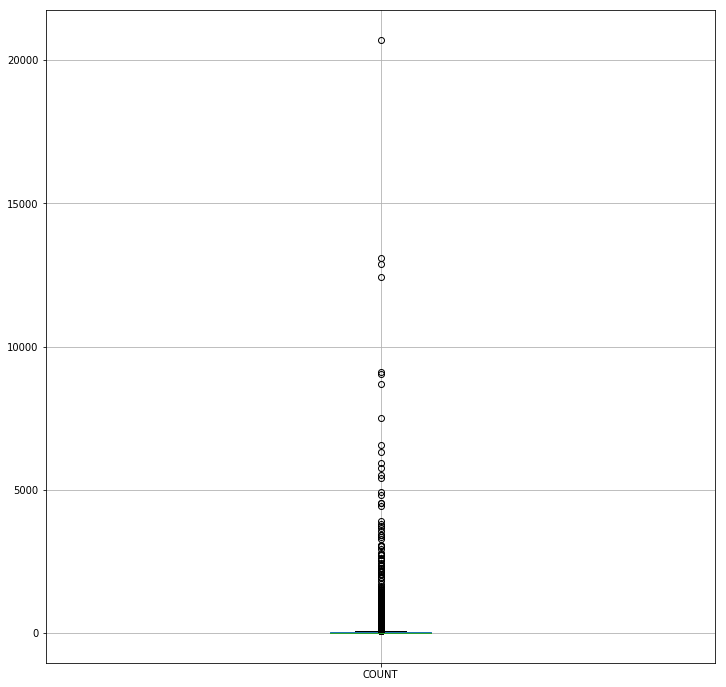

In [7]:
merge_count_df_nALL = merge_count_df.sort_values(by='COUNT', ascending=False)
merge_count_df_nALL.boxplot('COUNT', figsize=(12, 12))

In [8]:
merge_count_df_nALL.describe()

,COUNT
count,6841.000000
mean,92.780149
std,539.916435
min,1.000000
25%,2.000000
50%,6.000000
75%,28.000000
max,20703.000000


Notes:
    - Below code is grouping by subject and linking ICD9 codes each subject sees in there lifetime to see what are the relative ICD9 codes seen over a lifetime

In [9]:
import sys
from collections import Counter

ICD9_CODE_cross_initial = {}
unique_subjects = df_DIAGNOSES_ICD.loc[:, 'SUBJECT_ID'].unique()
unique_ICD9_CODE = df_DIAGNOSES_ICD.loc[:, 'ICD9_CODE'].unique()

for subject in unique_subjects:
    temp_df = df_DIAGNOSES_ICD[df_DIAGNOSES_ICD['SUBJECT_ID'] == subject]
    ICD9_CODE_list = temp_df['ICD9_CODE'].tolist()
    itr = 0
    for ICD9_CODE in ICD9_CODE_list:
        
        if ICD9_CODE not in ICD9_CODE_cross_initial.keys():
            ICD9_CODE_cross_initial[ICD9_CODE] = {}
        
        temp_ICD9_CODE_list = ICD9_CODE_list
        temp_ICD9_CODE_list.remove(ICD9_CODE_list[itr])
        temp_counter_key = Counter(temp_ICD9_CODE_list) 
        for value in temp_counter_key:
            if value not in ICD9_CODE_cross_initial[ICD9_CODE]:
                ICD9_CODE_cross_initial[ICD9_CODE][value] = temp_counter_key[value]
            else:
                ICD9_CODE_cross_initial[ICD9_CODE][value] += temp_counter_key[value]
        itr += 1

Notes:
    - Below code is grouping by visit (HADM_ID) and linking ICD9 codes each subject sees in a per visit aggregation to see what are the relative ICD9 codes during a visit

In [10]:
import sys
from collections import Counter

ICD9_CODE_cross_hadm = {}
unique_HADM_ID = df_DIAGNOSES_ICD.loc[:, 'HADM_ID'].unique()
unique_ICD9_CODE = df_DIAGNOSES_ICD.loc[:, 'ICD9_CODE'].unique()

for HADM_ID in unique_HADM_ID:
    temp_df = df_DIAGNOSES_ICD[df_DIAGNOSES_ICD['HADM_ID'] == HADM_ID]
    ICD9_CODE_list = temp_df['ICD9_CODE'].tolist()
    itr = 0
    for ICD9_CODE in ICD9_CODE_list:
        
        if ICD9_CODE not in ICD9_CODE_cross_hadm.keys():
            ICD9_CODE_cross_hadm[ICD9_CODE] = {}
        
        temp_ICD9_CODE_list = ICD9_CODE_list
        temp_ICD9_CODE_list.remove(ICD9_CODE_list[itr])
        temp_counter_key = Counter(temp_ICD9_CODE_list) 
        
        for value in temp_counter_key:
            if value not in ICD9_CODE_cross_hadm[ICD9_CODE]:
                ICD9_CODE_cross_hadm[ICD9_CODE][value] = temp_counter_key[value]
            else:
                ICD9_CODE_cross_hadm[ICD9_CODE][value] += temp_counter_key[value]
        itr += 1


Notes:
    - Below code shows what the top 50 ICD9 codes are linked to othe ICD9 codes over a subjects lifetime

In [13]:
itr = 1
for ICD9_CODE in merge_count_df_n100['ICD9_CODE']:
    temp_df = DataFrame([[key,value] for key,value in ICD9_CODE_cross_hadm[ICD9_CODE].items()],columns=['ICD9_CODE', 'COUNT'])
    temp_df = temp_df.sort_values(by='COUNT', ascending=False).head(10)
    
    merge_temp_df = temp_df.merge(df_D_ICD_DIAGNOSES, on='ICD9_CODE')
    temp_ill = df_D_ICD_DIAGNOSES[df_D_ICD_DIAGNOSES['ICD9_CODE'] == ICD9_CODE]
        
    print("ITR", itr, ":", temp_ill['LONG_TITLE'].get_values()[0], "Is linked up with other illness in same visit(HADM_ID)")
    print(merge_temp_df[['ICD9_CODE', 'COUNT', 'LONG_TITLE']])
    print('\n')
    itr += 1

ITR 1 : Unspecified essential hypertension Is linked up with other illness in same visit(HADM_ID)
  ICD9_CODE  COUNT                                         LONG_TITLE
0      2724   2486               Other and unspecified hyperlipidemia
1     25000   2166  Diabetes mellitus without mention of complicat...
2      2720   1897                          Pure hypercholesterolemia
3     42731   1832                                Atrial fibrillation
4     41401   1664  Coronary atherosclerosis of native coronary ar...
5      4280   1460              Congestive heart failure, unspecified
6     53081   1434                                  Esophageal reflux
7      2859   1044                                Anemia, unspecified
8      2449    979                Unspecified acquired hypothyroidism
9      5849    890                  Acute kidney failure, unspecified


ITR 2 : Congestive heart failure, unspecified Is linked up with other illness in same visit(HADM_ID)
  ICD9_CODE  COUNT           

ITR 12 : Need for prophylactic vaccination and inoculation against viral hepatitis Is linked up with other illness in same visit(HADM_ID)
  ICD9_CODE  COUNT                                         LONG_TITLE
0      V290   1908     Observation for suspected infectious condition
1      V502    805                     Routine or ritual circumcision
2      7742    293  Neonatal jaundice associated with preterm deli...
3     76519    236        Other preterm infants, 2,500 grams and over
4     76518    228           Other preterm infants, 2,000-2,499 grams
5       769    205           Respiratory distress syndrome in newborn
6      7706    201                    Transitory tachypnea of newborn
7     77081    158                           Primary apnea of newborn


ITR 13 : Observation for suspected infectious condition Is linked up with other illness in same visit(HADM_ID)
  ICD9_CODE  COUNT                                         LONG_TITLE
0      V053   1755  Need for prophylactic vaccina

ITR 27 : Hypertensive chronic kidney disease, unspecified, with chronic kidney disease stage I through stage IV, or unspecified Is linked up with other illness in same visit(HADM_ID)
  ICD9_CODE  COUNT                                         LONG_TITLE
0      5859   1018                Chronic kidney disease, unspecified
1      4280    578              Congestive heart failure, unspecified
2      2724    520               Other and unspecified hyperlipidemia
3      5849    503                  Acute kidney failure, unspecified
4     42731    462                                Atrial fibrillation
5     25000    382  Diabetes mellitus without mention of complicat...
6     41401    347  Coronary atherosclerosis of native coronary ar...
7     53081    254                                  Esophageal reflux
8     V5861    246          Long-term (current) use of anticoagulants
9      2449    236                Unspecified acquired hypothyroidism


ITR 28 : Tobacco use disorder Is linked up wi

ITR 41 : Aortic valve disorders Is linked up with other illness in same visit(HADM_ID)
  ICD9_CODE  COUNT                                         LONG_TITLE
0      4019    941                 Unspecified essential hypertension
1     42731    762                                Atrial fibrillation
2     41401    699  Coronary atherosclerosis of native coronary ar...
3      4280    652              Congestive heart failure, unspecified
4      2724    564               Other and unspecified hyperlipidemia
5     25000    378  Diabetes mellitus without mention of complicat...
6      2720    303                          Pure hypercholesterolemia
7     53081    297                                  Esophageal reflux
8      9971    267    Cardiac complications, not elsewhere classified
9      2859    255                                Anemia, unspecified


ITR 42 : Long-term (current) use of insulin Is linked up with other illness in same visit(HADM_ID)
  ICD9_CODE  COUNT                        

ITR 56 : Routine or ritual circumcision Is linked up with other illness in same visit(HADM_ID)
  ICD9_CODE  COUNT                                         LONG_TITLE
0      V053    806  Need for prophylactic vaccination and inoculat...
1      V290    633     Observation for suspected infectious condition
2      7706     98                    Transitory tachypnea of newborn
3      7742     93  Neonatal jaundice associated with preterm deli...
4     76519     90        Other preterm infants, 2,500 grams and over
5     76518     87           Other preterm infants, 2,000-2,499 grams
6      7746     69            Unspecified fetal and neonatal jaundice
7     77089     69             Other respiratory problems after birth
8       769     68           Respiratory distress syndrome in newborn


ITR 57 : Osteoporosis, unspecified Is linked up with other illness in same visit(HADM_ID)
  ICD9_CODE  COUNT                                         LONG_TITLE
0      4019    294                 Unspecif

ITR 71 : Bacteremia Is linked up with other illness in same visit(HADM_ID)
  ICD9_CODE  COUNT                                         LONG_TITLE
0      4019    233                 Unspecified essential hypertension
1      4280    183              Congestive heart failure, unspecified
2      5990    157        Urinary tract infection, site not specified
3     42731    154                                Atrial fibrillation
4      5849    147                  Acute kidney failure, unspecified
5     25000    136  Diabetes mellitus without mention of complicat...
6     04111    113  Methicillin susceptible Staphylococcus aureus ...
7     51881    106                          Acute respiratory failure
8     41401     91  Coronary atherosclerosis of native coronary ar...
9      2859     90                                Anemia, unspecified


ITR 72 : Delirium due to conditions classified elsewhere Is linked up with other illness in same visit(HADM_ID)
  ICD9_CODE  COUNT                       

ITR 86 : Hypoxemia Is linked up with other illness in same visit(HADM_ID)
  ICD9_CODE  COUNT                                         LONG_TITLE
0      4019    199                 Unspecified essential hypertension
1      4280    165              Congestive heart failure, unspecified
2      5849    138                  Acute kidney failure, unspecified
3     42731    132                                Atrial fibrillation
4      2724    128               Other and unspecified hyperlipidemia
5     53081    104                                  Esophageal reflux
6       486     91                    Pneumonia, organism unspecified
7      2859     90                                Anemia, unspecified
8     25000     85  Diabetes mellitus without mention of complicat...
9      2449     84                Unspecified acquired hypothyroidism


ITR 87 : Pressure ulcer, lower back Is linked up with other illness in same visit(HADM_ID)
  ICD9_CODE  COUNT                                         LONG

Notes:
    - Below code shows what the top 50 ICD9 codes are linked to othe ICD9 codes per visit of a subject

In [14]:
itr = 1
for ICD9_CODE in merge_count_df_n100['ICD9_CODE']:
    temp_df = DataFrame([[key,value] for key,value in ICD9_CODE_cross_initial[ICD9_CODE].items()],columns=['ICD9_CODE', 'COUNT'])
    temp_df = temp_df.sort_values(by='COUNT', ascending=False).head(10)
    
    merge_temp_df = temp_df.merge(df_D_ICD_DIAGNOSES, on='ICD9_CODE')
    temp_ill = df_D_ICD_DIAGNOSES[df_D_ICD_DIAGNOSES['ICD9_CODE'] == ICD9_CODE]
        
    print("ITR", itr, ":", temp_ill['LONG_TITLE'].get_values()[0], "Is linked up with same patient symptoms over lifetime")
    print(merge_temp_df[['ICD9_CODE', 'COUNT', 'LONG_TITLE']])
    print('\n')
    itr += 1

ITR 1 : Unspecified essential hypertension Is linked up with same patient symptoms over lifetime
  ICD9_CODE  COUNT                                         LONG_TITLE
0      2724   3804               Other and unspecified hyperlipidemia
1      4019   3697                 Unspecified essential hypertension
2      4280   3526              Congestive heart failure, unspecified
3     25000   3511  Diabetes mellitus without mention of complicat...
4     42731   3503                                Atrial fibrillation
5     41401   3044  Coronary atherosclerosis of native coronary ar...
6      2720   2641                          Pure hypercholesterolemia
7     53081   2607                                  Esophageal reflux
8      5849   2339                  Acute kidney failure, unspecified
9     51881   1866                          Acute respiratory failure


ITR 2 : Congestive heart failure, unspecified Is linked up with same patient symptoms over lifetime
  ICD9_CODE  COUNT             

ITR 12 : Need for prophylactic vaccination and inoculation against viral hepatitis Is linked up with same patient symptoms over lifetime
  ICD9_CODE  COUNT                                         LONG_TITLE
0      V290   1921     Observation for suspected infectious condition
1      V502    803                     Routine or ritual circumcision
2      7742    304  Neonatal jaundice associated with preterm deli...
3     76519    237        Other preterm infants, 2,500 grams and over
4     76518    229           Other preterm infants, 2,000-2,499 grams
5       769    211           Respiratory distress syndrome in newborn
6      7706    200                    Transitory tachypnea of newborn
7     77081    161                           Primary apnea of newborn


ITR 13 : Observation for suspected infectious condition Is linked up with same patient symptoms over lifetime
  ICD9_CODE  COUNT                                         LONG_TITLE
0      V053   1771  Need for prophylactic vaccinati

ITR 27 : Hypertensive chronic kidney disease, unspecified, with chronic kidney disease stage I through stage IV, or unspecified Is linked up with same patient symptoms over lifetime
  ICD9_CODE  COUNT                                         LONG_TITLE
0      5859   1492                Chronic kidney disease, unspecified
1      4280   1428              Congestive heart failure, unspecified
2      5849   1098                  Acute kidney failure, unspecified
3     42731    990                                Atrial fibrillation
4      2724    867               Other and unspecified hyperlipidemia
5     41401    763  Coronary atherosclerosis of native coronary ar...
6     25000    740  Diabetes mellitus without mention of complicat...
7     40390    622  Hypertensive chronic kidney disease, unspecifi...
8      2449    443                Unspecified acquired hypothyroidism
9     53081    439                                  Esophageal reflux


ITR 28 : Tobacco use disorder Is linked up wit

ITR 42 : Long-term (current) use of insulin Is linked up with same patient symptoms over lifetime
  ICD9_CODE  COUNT                                         LONG_TITLE
0      4280   1134              Congestive heart failure, unspecified
1      5849    930                  Acute kidney failure, unspecified
2      2724    916               Other and unspecified hyperlipidemia
3     25000    880  Diabetes mellitus without mention of complicat...
4      4019    872                 Unspecified essential hypertension
5     V5867    784                 Long-term (current) use of insulin
6      3572    638                         Polyneuropathy in diabetes
7     42731    589                                Atrial fibrillation
8     41401    571  Coronary atherosclerosis of native coronary ar...
9       311    500      Depressive disorder, not elsewhere classified


ITR 43 : Other specified cardiac dysrhythmias Is linked up with same patient symptoms over lifetime
  ICD9_CODE  COUNT            

ITR 53 : Other iatrogenic hypotension Is linked up with same patient symptoms over lifetime
  ICD9_CODE  COUNT                                         LONG_TITLE
0      4019    601                 Unspecified essential hypertension
1      4280    449              Congestive heart failure, unspecified
2     42731    442                                Atrial fibrillation
3      2724    420               Other and unspecified hyperlipidemia
4     41401    396  Coronary atherosclerosis of native coronary ar...
5     25000    299  Diabetes mellitus without mention of complicat...
6     53081    276                                  Esophageal reflux
7       496    229  Chronic airway obstruction, not elsewhere clas...
8      5849    223                  Acute kidney failure, unspecified
9      2859    215                                Anemia, unspecified


ITR 54 : Gout, unspecified Is linked up with same patient symptoms over lifetime
  ICD9_CODE  COUNT                                     

ITR 67 : Obesity, unspecified Is linked up with same patient symptoms over lifetime
  ICD9_CODE  COUNT                                         LONG_TITLE
0      4019    547                 Unspecified essential hypertension
1      4280    419              Congestive heart failure, unspecified
2     25000    339  Diabetes mellitus without mention of complicat...
3      2724    301               Other and unspecified hyperlipidemia
4     32723    292         Obstructive sleep apnea (adult)(pediatric)
5     42731    275                                Atrial fibrillation
6      5849    247                  Acute kidney failure, unspecified
7     53081    243                                  Esophageal reflux
8     41401    241  Coronary atherosclerosis of native coronary ar...
9     51881    177                          Acute respiratory failure


ITR 68 : Other specified procedures as the cause of abnormal reaction of patient, or of later complication, without mention of misadventure at t

ITR 81 : Intracerebral hemorrhage Is linked up with same patient symptoms over lifetime
  ICD9_CODE  COUNT                                         LONG_TITLE
0      4019    772                 Unspecified essential hypertension
1     42731    284                                Atrial fibrillation
2      5990    220        Urinary tract infection, site not specified
3     25000    208  Diabetes mellitus without mention of complicat...
4      3485    204                                     Cerebral edema
5      2724    199               Other and unspecified hyperlipidemia
6     51881    185                          Acute respiratory failure
7      3484    178                               Compression of brain
8      3314    174                          Obstructive hydrocephalus
9     V5861    160          Long-term (current) use of anticoagulants


ITR 82 : Cardiac arrest Is linked up with same patient symptoms over lifetime
  ICD9_CODE  COUNT                                         LON

  ICD9_CODE  COUNT                                         LONG_TITLE
0     07054    715  Chronic hepatitis C without mention of hepatic...
1      4019    365                 Unspecified essential hypertension
2      4280    354              Congestive heart failure, unspecified
3     07032    318  Chronic viral hepatitis B without mention of h...
4     29181    316                                 Alcohol withdrawal
5      5849    315                  Acute kidney failure, unspecified
6      V600    313                                    Lack of housing
7      5715    288      Cirrhosis of liver without mention of alcohol
8     51881    258                          Acute respiratory failure
9     40391    241  Hypertensive chronic kidney disease, unspecifi...


ITR 96 : Atrial flutter Is linked up with same patient symptoms over lifetime
  ICD9_CODE  COUNT                                         LONG_TITLE
0     42731    662                                Atrial fibrillation
1      428

Notes:
    - Below code shows what the diagnosis of the admission is and linkage to the ICD9 codes

In [15]:
df_ADMISSIONS = read_csv("ADMISSIONS.csv")
df_ADMISSIONS.head()


,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


In [16]:
HADM_ID_unique_list = df_DIAGNOSES_ICD['HADM_ID'].unique()
master_df_list = []
ICD9_CODE_master_list = []
diagnosis_list = []
for HADM_ID in HADM_ID_unique_list:
    temp_ICD9_CODE_list = []
    diagnosis_list.append(df_ADMISSIONS[df_ADMISSIONS['HADM_ID'] == HADM_ID]['DIAGNOSIS'].get_values()[0])
    for i in df_DIAGNOSES_ICD[df_DIAGNOSES_ICD['HADM_ID'] == HADM_ID]['ICD9_CODE']:
        temp_ICD9_CODE_list.append(i)
    ICD9_CODE_master_list.append(temp_ICD9_CODE_list)

In [45]:
master_df_list = []
master_df_list.append(HADM_ID_unique_list)
master_df_list.append(ICD9_CODE_master_list)
master_df_list.append(diagnosis_list)

df_admission_merge = DataFrame(master_df_list).transpose()
df_admission_merge.columns = ['HADM_ID', 'ICD9_CODE', 'diagnosis']

In [46]:
df_admission_merge_unique = df_admission_merge[:].groupby(['diagnosis']).count().reset_index()
df_admission_merge_unique = df_admission_merge_unique[['diagnosis', 'HADM_ID']]
df_admission_merge_unique.columns = ['diagnosis', 'COUNT']
df_admission_merge_unique = df_admission_merge_unique.sort_values(by='COUNT', ascending=False)
unique_diagnosis = df_admission_merge_unique['diagnosis'].unique()

In [48]:
itr = 1
for diagnosis in unique_diagnosis[:50]:
    temp_dict = {}
    
    temp_df_itr = df_admission_merge[df_admission_merge['diagnosis'] == diagnosis]['ICD9_CODE']
    length_temp_df = len(temp_df_itr)
    for ICD9_CODE in temp_df_itr:
        for i in ICD9_CODE:

            temp_counter = Counter(ICD9_CODE)

            if i not in temp_dict.keys():
                temp_dict[i] = temp_counter[i]
            else:
                temp_dict[i] += temp_counter[i]

    temp_df = DataFrame([[key,value] for key,value in temp_dict.items()],columns=['ICD9_CODE', 'COUNT'])
    temp_df = temp_df.sort_values(by='COUNT', ascending=False).head(10)
    temp_df = temp_df.merge(df_D_ICD_DIAGNOSES, on='ICD9_CODE')
    print("ITR ", itr, ": FOR DIAGNOSIS:", diagnosis, "TOTAL CASES:", length_temp_df)
    print(temp_df[['ICD9_CODE', 'COUNT', 'LONG_TITLE']])
    print('\n')
    itr += 1

ITR  1 : FOR DIAGNOSIS: NEWBORN TOTAL CASES: 7823
  ICD9_CODE  COUNT                                         LONG_TITLE
0      V053   5717  Need for prophylactic vaccination and inoculat...
1      V290   5458     Observation for suspected infectious condition
2     V3000   3566  Single liveborn, born in hospital, delivered w...
3     V3001   2756  Single liveborn, born in hospital, delivered b...
4      7742   2205  Neonatal jaundice associated with preterm deli...
5      V502   1999                     Routine or ritual circumcision
6       769   1280           Respiratory distress syndrome in newborn
7     77081   1006                           Primary apnea of newborn
8     V3101   1000  Twin birth, mate liveborn, born in hospital, d...


ITR  2 : FOR DIAGNOSIS: PNEUMONIA TOTAL CASES: 1566
  ICD9_CODE  COUNT                                        LONG_TITLE
0       486    676                   Pneumonia, organism unspecified
1      4280    605             Congestive heart failure, u

ITR  14 : FOR DIAGNOSIS: DIABETIC KETOACIDOSIS TOTAL CASES: 462
  ICD9_CODE  COUNT                                         LONG_TITLE
0     25013    267  Diabetes with ketoacidosis, type I [juvenile t...
1     V5867    197                 Long-term (current) use of insulin
2      5849    175                  Acute kidney failure, unspecified
3      4019    130                 Unspecified essential hypertension
4     25063    100  Diabetes with neurological manifestations, typ...
5      2724     90               Other and unspecified hyperlipidemia
6      3572     88                         Polyneuropathy in diabetes
7      5363     88                                      Gastroparesis
8     25011     85  Diabetes with ketoacidosis, type I [juvenile t...
9     V1581     77  Personal history of noncompliance with medical...


ITR  15 : FOR DIAGNOSIS: CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS GRAFT/SDA TOTAL CASES: 450
  ICD9_CODE  COUNT                                         LONG_T

ITR  25 : FOR DIAGNOSIS: RESPIRATORY FAILURE TOTAL CASES: 247
  ICD9_CODE  COUNT                                         LONG_TITLE
0     51881    174                          Acute respiratory failure
1      4280    113              Congestive heart failure, unspecified
2      4019     84                 Unspecified essential hypertension
3      5849     64                  Acute kidney failure, unspecified
4     42731     60                                Atrial fibrillation
5       486     55                    Pneumonia, organism unspecified
6      5070     54   Pneumonitis due to inhalation of food or vomitus
7      5990     47        Urinary tract infection, site not specified
8     25000     44  Diabetes mellitus without mention of complicat...
9       496     43  Chronic airway obstruction, not elsewhere clas...


ITR  26 : FOR DIAGNOSIS: S/P MOTOR VEHICLE ACCIDENT TOTAL CASES: 241
  ICD9_CODE  COUNT                                         LONG_TITLE
0     86121     54  Contusi

ITR  39 : FOR DIAGNOSIS: LOWER GASTROINTESTINAL BLEED TOTAL CASES: 168
  ICD9_CODE  COUNT                                         LONG_TITLE
0      2851     94                       Acute posthemorrhagic anemia
1      4019     73                 Unspecified essential hypertension
2     42731     55                                Atrial fibrillation
3      5789     55  Hemorrhage of gastrointestinal tract, unspecified
4      4280     43              Congestive heart failure, unspecified
5     25000     42  Diabetes mellitus without mention of complicat...
6     56212     40            Diverticulosis of colon with hemorrhage
7      5849     39                  Acute kidney failure, unspecified
8      2724     37               Other and unspecified hyperlipidemia
9     56210     31  Diverticulosis of colon (without mention of he...


ITR  40 : FOR DIAGNOSIS: CELLULITIS TOTAL CASES: 167
  ICD9_CODE  COUNT                                         LONG_TITLE
0      6826     84         Celluli